# 简单线性回归纯手写的实现
来自于李沐的线上网课， 不调用torch的一些库，只使用python的numpy和matplotlib，使用torch或者深度学习的思路来实现整个流程。

In [29]:
import numpy as np
import torch
import matplotlib.pyplot as plt
import random
%matplotlib inline

## 1. 创建伪造的数据或者数据集
使用真实的`w=[4,-1.2].T, b=4.2`来创建数据集，并且加入一些噪音，否则线性回归问题是以一个可以在数学上推导出准确解的问题，这里的噪音是为了模拟真实的数据。
`y = Wx + b + noise`

In [30]:
# 人造数据集
def synthetic_data(weight, bias, num_samples):
    x = torch.normal(0, 1, (num_samples, len(weight)))  # normal函数 均值为0，方差为1的正态分布
    # 矩阵乘以向量
    y = torch.matmul(x, weight) + bias
    y += torch.normal(0, 0.01, y.shape) # 添加噪声
    return x, y
w = torch.tensor([4.0, -1.2], dtype=torch.float32).T
b = torch.tensor(4.2, dtype=torch.float32)
features, labels = synthetic_data(w, b, 1000)
print(features.shape, labels.shape)
print(features[0], labels[0])

torch.Size([1000, 2]) torch.Size([1000])
tensor([-0.3211, -0.9573]) tensor(4.0517)


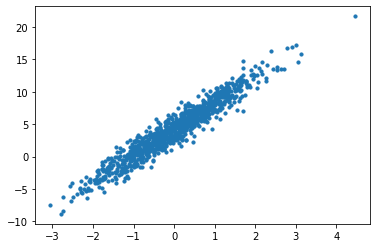

In [10]:
plt.scatter(features[:, 0], labels, s=10)
plt.show()

## 2.  创建数据加载器迭代加载数据集
小批量的读取数据集，可以使得训练满足自己的设备的要求，在某种程度上也能够提高训练速度和准确率。

torch.Size([8, 2]) torch.Size([8])
tensor([[-0.0382, -1.1908],
        [-0.5629,  0.1095],
        [-1.0741,  1.2071],
        [ 0.2794, -1.0648],
        [ 0.7123,  0.2940],
        [ 0.7123,  0.2940],
        [ 0.8688, -0.5899],
        [ 1.9809, -0.0817]]) tensor([ 4.1631,  3.4730,  9.8947, -0.8093,  4.7389, 10.2123,  8.4841,  2.9222])


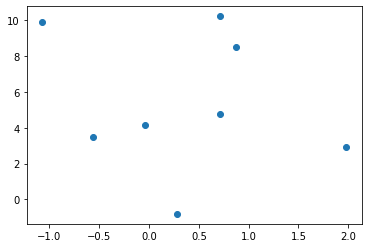

In [40]:
def data_iter(batch_size, features, labels):
    """
    打乱数据集，并每次读取一个批量的数据
    params:
        @batch_size: 批量的大小
        @features: 特征矩阵或者向量集合
        @labels: 标签集合
    return:
        yield 返回每个批次的数据集
    """
    num_samples = len(features)  # 获取总数
    indices = list(range(num_samples))  # 获取所有元素的下标
    random.shuffle(indices)  # 打乱这些下标，保证数据的随机读取
    # for i in range(1, int(num_samples / batch_size)):  自己实现的写法，不太完善
    #     index_end = i * batch_size
    #     index_start = index_end - batch_size
    #     yield features[index_start:index_end,:],labels[index_start:index_end]
    
    # 按照打乱的下标切分并读取
    for i in range(1, int(num_samples / batch_size)):
        indice = indices[i * batch_size - batch_size:min(batch_size * i, num_samples)]  # 后面的min是防止溢出
        yield features[indice], labels[indice]

for X, y in data_iter(8, features, labels):
    print(X.shape, y.shape)
    print(X, y)
    break
plt.scatter(X.numpy()[:,0], y.numpy())
plt.show()


## 3. 对模型的参数进行初始化
初始化模型的参数`w`和`b`

In [58]:
w = torch.randn([2,1], requires_grad=True)
b = torch.zeros(1, requires_grad = True)
print(w, b)

tensor([[ 0.9898],
        [-0.1789]], requires_grad=True) tensor([0.], requires_grad=True)


## 4. 创建线性回归模型
创建线性回归模型函数，也就是y = wx + b

In [62]:
def linear(weight, bais, feature):
    """
    params:
        weight: 权重
        bais: 偏移
        x: batch_size 的向量集合
    """
    y = torch.matmul(feature, weight) + bais
    return y




## 5. 定义损失函数
使用平方误差函数，也就是预测值与真实值之间的差值的平方的1/2

In [63]:
def squared_loss(predict, labels):
    """
    @predict: 预测值 shape=(8,1)
    @labels: 真实值 shape=(8,)
    """
    return (labels - predict.reshape(labels.shape)) **2 / 2

## 6. 定义优化函数
核心就是梯度的方向就是变化最大的方向，而上面的损失函数的值最小，表示整个模型的精度越高，所以这个最优化问题就是使得上述的损失函数值最小。
利用梯度下降法，找到梯度最大的地方，然后计算出按照此梯度下降之后的值，从而计算出其参数，用来更新我门原来的参数。

In [64]:
def sgd(params, lr, batch_size):
    """
    @params: 模型的参数， params.grad 就是参数的梯度
    @lr: 在梯度的方向下降的大小
    @batch_size: 批量的大小
    """
    with torch.no_grad():
        for param in params:
            # 在梯度的方向下降
            param -= param.grad * lr / batch_size
            param.grad.zero_()

## 7. 模型的训练
有了损失函数，模型，优化器，就可以开始对模型进行训练了。

In [84]:
# 定义迭代的次数
num_epochs = 50
loss_fn = squared_loss
lr = 0.01
batch_size = 10
for i in range(num_epochs):
    for X, Y in data_iter(batch_size, features, labels):
        #  首先是前向传播计算一次预测结果
        predicts = linear(w, b, X)
        print(predicts)
        pr
        # 计算损失
        loss = loss_fn(predicts, Y)
        # print(loss)
        # 损失方向传播计算梯度,每一个的单独的损失求和，也就是一个小批量的所有的损失，所有的损失再求梯度，最后得到的也就是整个损失的梯度
        loss.sum().backward()  # 利用张量的反向传播的性质可以直接求梯度,也就是求了w和b的梯度，结果会存在w和b张量里面
        # 利用求出来的梯度进行优化
        sgd([w,b], lr, batch_size)
    with torch.no_grad():
        train_loss = loss_fn(linear(w, b, features), labels).sum()
        print("Epoch {}, loss {:.2f}".format(i, train_loss))
 
print(w, b)


tensor([ 3.2448,  0.9627, 20.6046,  1.3194,  5.7448, 17.0450,  2.1339,  5.0877,
         1.2704,  4.6021], grad_fn=<DivBackward0>)
tensor([ 3.7837,  7.7402, 16.5352,  0.1309,  6.1214,  3.3572,  3.1743,  0.0380,
         1.6349,  1.8746], grad_fn=<DivBackward0>)
tensor([3.7266e-01, 8.4558e+00, 7.6663e-03, 9.0650e-02, 6.3898e+00, 2.1838e-02,
        3.6651e+00, 6.0151e+00, 4.0467e+00, 1.8046e+00],
       grad_fn=<DivBackward0>)
tensor([38.8922,  6.8570,  0.4895, 10.0277,  6.3070,  5.7555,  7.1284, 50.0630,
         3.0994, 10.1878], grad_fn=<DivBackward0>)
tensor([ 7.4207,  3.2499, 54.7516,  0.2108,  3.5812,  7.0185,  1.2555,  0.0684,
        32.8487,  3.4176], grad_fn=<DivBackward0>)
tensor([10.6221, 23.1647,  2.4475,  3.6830,  0.1855, 10.3871,  0.8578,  0.2818,
        22.9906, 10.0061], grad_fn=<DivBackward0>)
tensor([3.4231e+01, 1.9148e+00, 4.9436e+00, 1.8679e+00, 7.8691e+00, 1.3294e-03,
        4.0457e-02, 9.1396e+00, 1.5460e+01, 6.7497e-01],
       grad_fn=<DivBackward0>)
tensor([7